In [1]:
# Setup and Imports
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# File paths
DATASET_PATH = '/content/drive/MyDrive/CSE422/labProject/travel_insurance.csv'
OUTPUT_DIR = 'outputs'
RANDOM_STATE = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)
print('OUTPUT_DIR =', os.path.abspath(OUTPUT_DIR))

from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv(DATASET_PATH)
print("Dataset loaded successfully!")
print("Shape:", df.shape)


OUTPUT_DIR = /content/outputs
Mounted at /content/drive
Dataset loaded successfully!
Shape: (63326, 11)


In [2]:
df.describe(include='all')

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
count,63326,63326,63326,63326,63326,63326.000000,63326,63326.000000,63326.000000,18219,63326.000000
unique,16,2,2,26,2,NaN,149,NaN,NaN,2,NaN
top,EPX,Travel Agency,Online,Cancellation Plan,No,NaN,SINGAPORE,NaN,NaN,M,NaN
freq,35119,45869,62219,18630,62399,NaN,13255,NaN,NaN,9347,NaN
mean,NaN,NaN,NaN,NaN,NaN,49.317074,NaN,40.702018,9.809992,NaN,39.969981
std,NaN,NaN,NaN,NaN,NaN,101.791566,NaN,48.845637,19.804388,NaN,14.017010
min,NaN,NaN,NaN,NaN,NaN,-2.000000,NaN,-389.000000,0.000000,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,18.000000,0.000000,NaN,35.000000
50%,NaN,NaN,NaN,NaN,NaN,22.000000,NaN,26.530000,0.000000,NaN,36.000000
75%,NaN,NaN,NaN,NaN,NaN,53.000000,NaN,48.000000,11.550000,NaN,43.000000


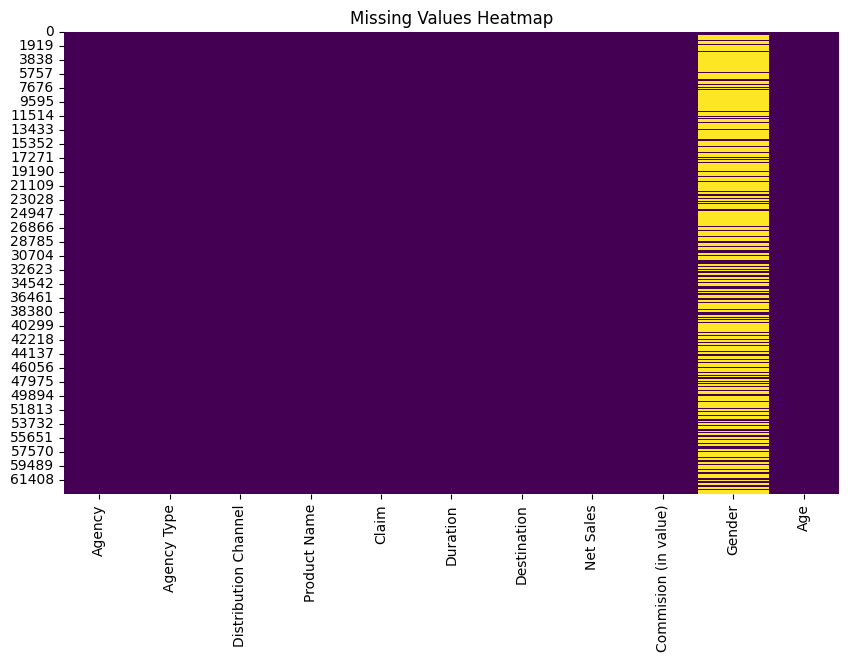

Agency                      0
Agency Type                 0
Distribution Channel        0
Product Name                0
Claim                       0
Duration                    0
Destination                 0
Net Sales                   0
Commision (in value)        0
Gender                  45107
Age                         0
dtype: int64


In [3]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

print(df.isnull().sum())

In [4]:
df['Claim'] = df['Claim'].map({'Yes': 1, 'No': 0})

print("Claim value counts after conversion:")
print(df['Claim'].value_counts())

df['Gender'] = df['Gender'].fillna('Unknown')

Claim value counts after conversion:
Claim
0    62399
1      927
Name: count, dtype: int64


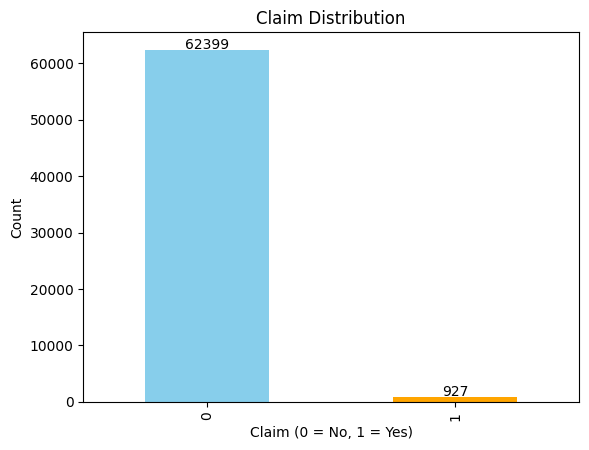

In [5]:
counts = df['Claim'].value_counts()
ax = counts.plot(kind='bar', color=['skyblue','orange'])
for i, val in enumerate(counts):
    ax.text(i, val + 200, str(val), ha='center')
plt.title('Claim Distribution')
plt.xlabel('Claim (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


In [ ]:
df_sample = df.head(500)
print("Sample shape:", df_sample.shape)

Sample shape: (500, 11)


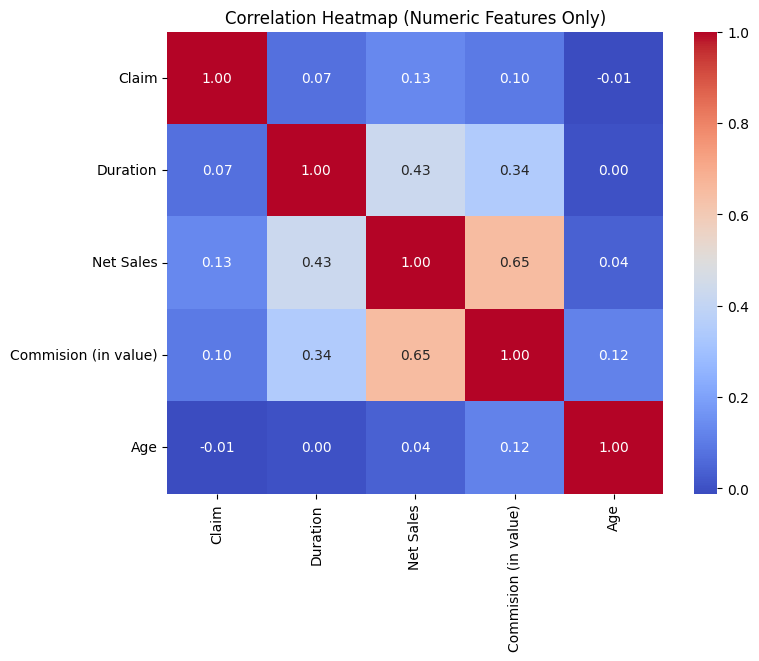

In [6]:
numeric_cols = df.select_dtypes(include=np.number)

plt.figure(figsize=(8,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

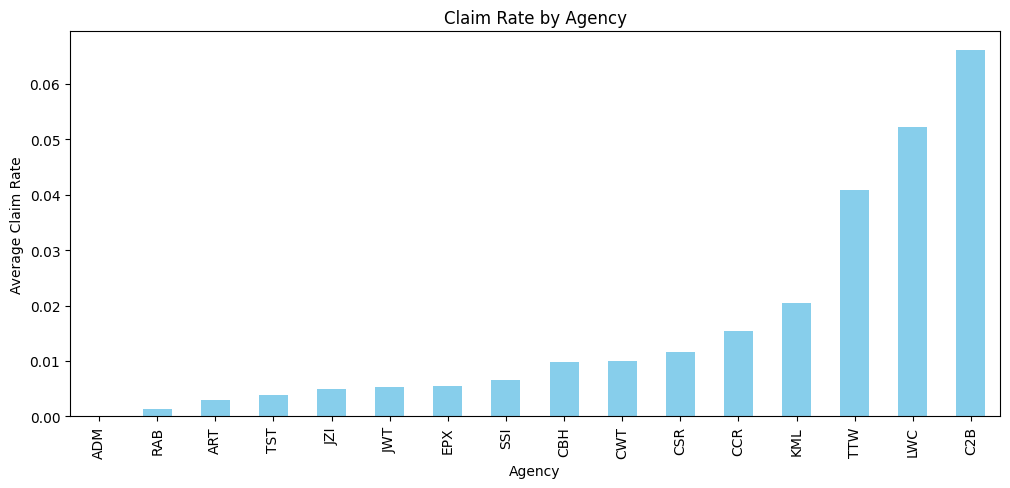

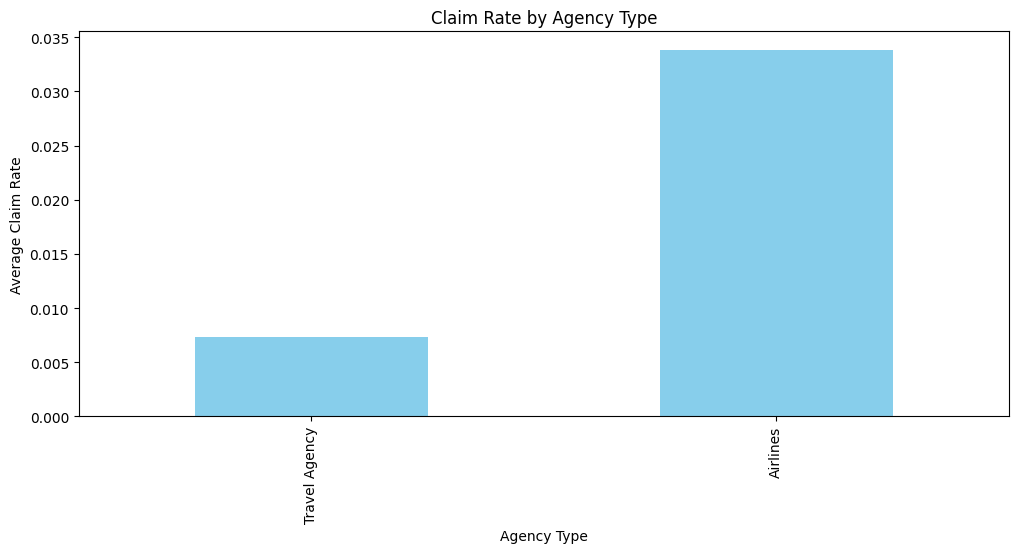

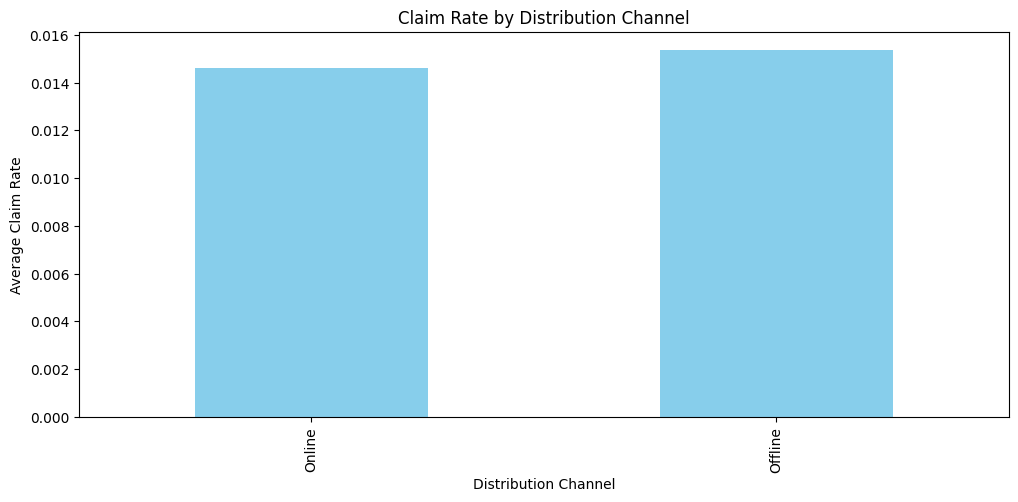

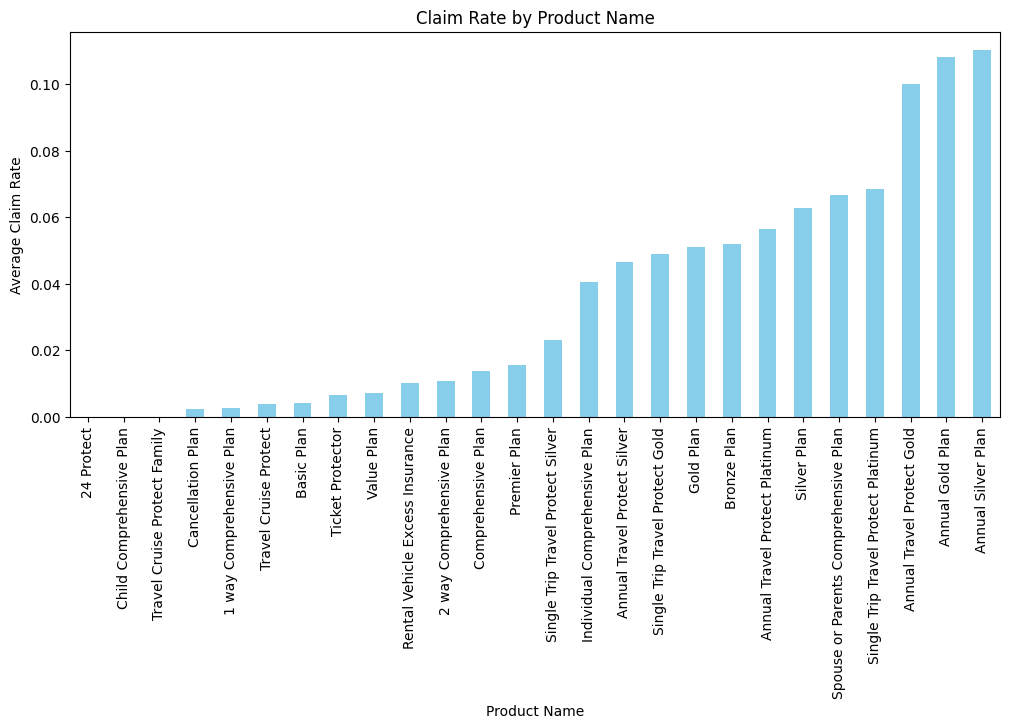

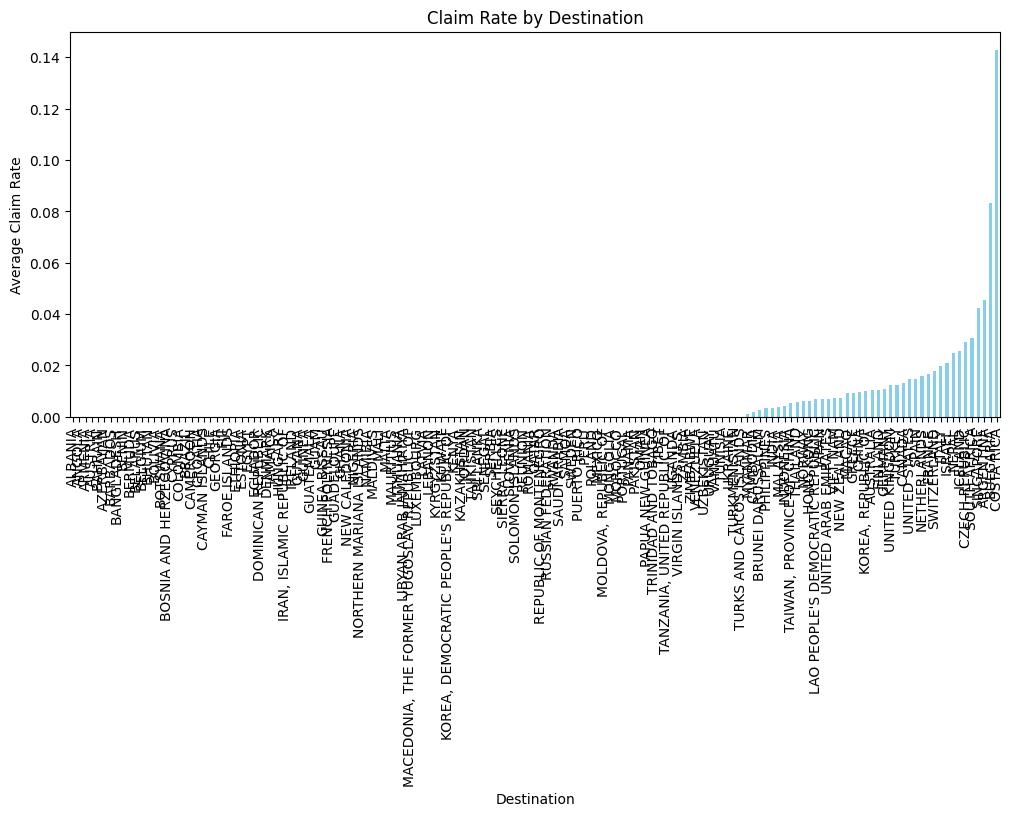

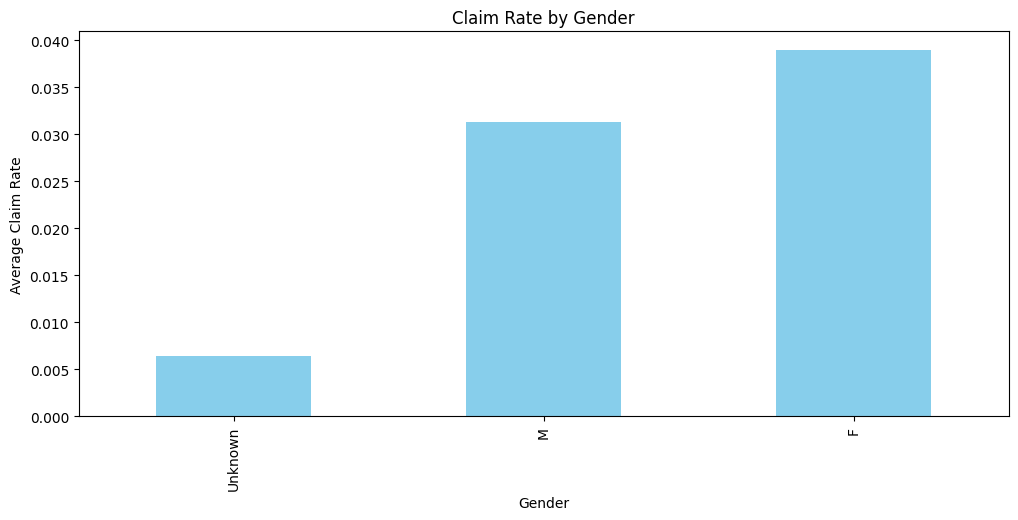

In [7]:
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel',
                    'Product Name', 'Destination', 'Gender']

for col in categorical_cols:
    plt.figure(figsize=(12,5))
    claim_rate = df.groupby(col)['Claim'].mean().sort_values()
    claim_rate.plot(kind='bar', color='skyblue')
    plt.title(f'Claim Rate by {col}')
    plt.ylabel('Average Claim Rate')
    plt.xlabel(col)
    plt.show()

In [8]:
numeric_cols = ['Duration', 'Net Sales', 'Commision (in value)', 'Age']
categorical_cols = ['Agency', 'Agency Type', 'Distribution Channel',
                    'Product Name', 'Destination', 'Gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [9]:
X = df.drop('Claim', axis=1)
y = df['Claim']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (50660, 10)
X_test shape: (12666, 10)
y_train distribution:
 Claim
0    49918
1      742
Name: count, dtype: int64
y_test distribution:
 Claim
0    12481
1      185
Name: count, dtype: int64


In [10]:
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=RANDOM_STATE)
}

trained_pipelines = {}
y_preds = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    trained_pipelines[name] = pipeline
    y_preds[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


Training Logistic Regression...
Logistic Regression Accuracy: 0.7952

Training Decision Tree...
Decision Tree Accuracy: 0.9713

Training Neural Network...
Neural Network Accuracy: 0.9854



Logistic Regression Evaluation Metrics:
----------------------------------------
Accuracy: 0.7952
Precision: 0.0517
Recall: 0.7514
F1-score: 0.0968
AUC: 0.8312


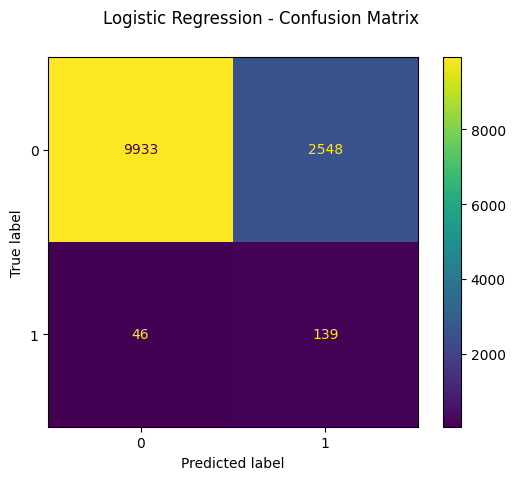

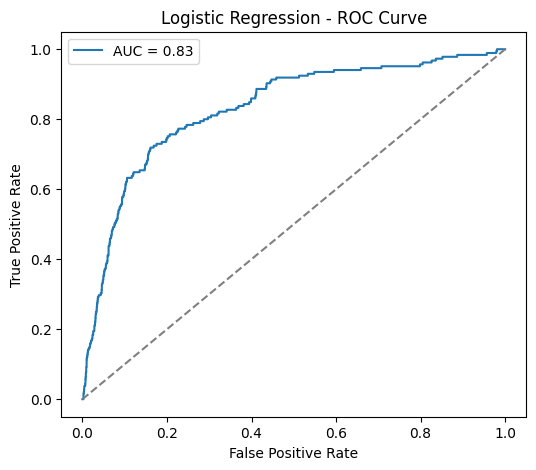


Decision Tree Evaluation Metrics:
----------------------------------------
Accuracy: 0.9713
Precision: 0.0680
Recall: 0.0757
F1-score: 0.0716
AUC: 0.5319


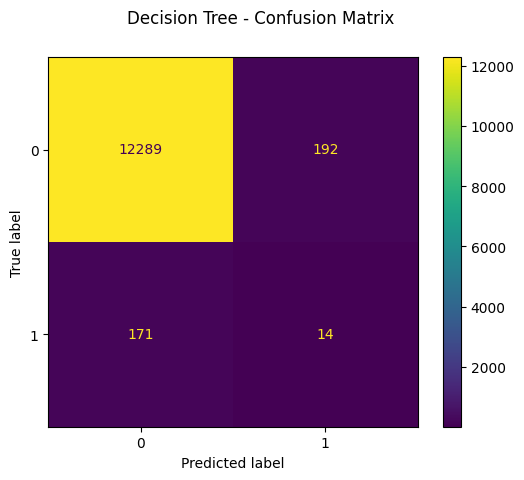

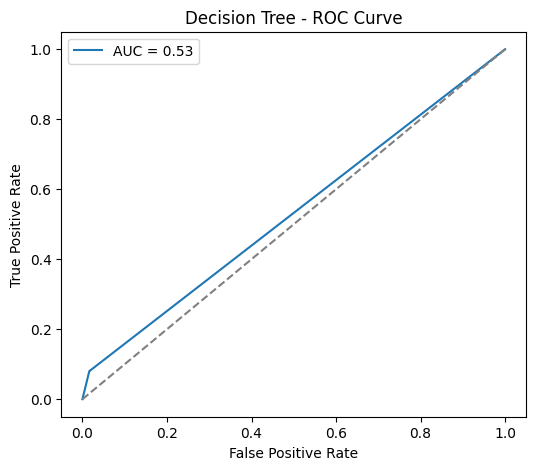


Neural Network Evaluation Metrics:
----------------------------------------
Accuracy: 0.9854
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
AUC: 0.8383


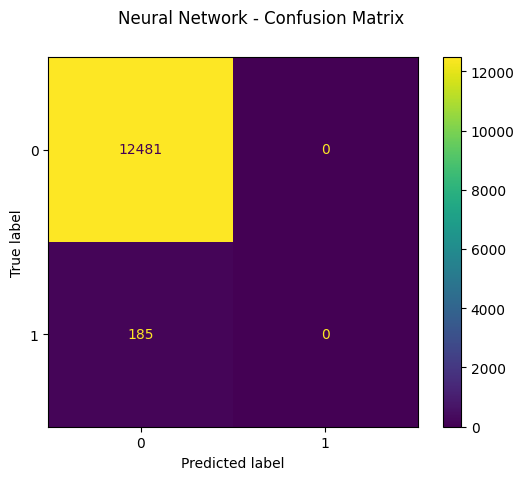

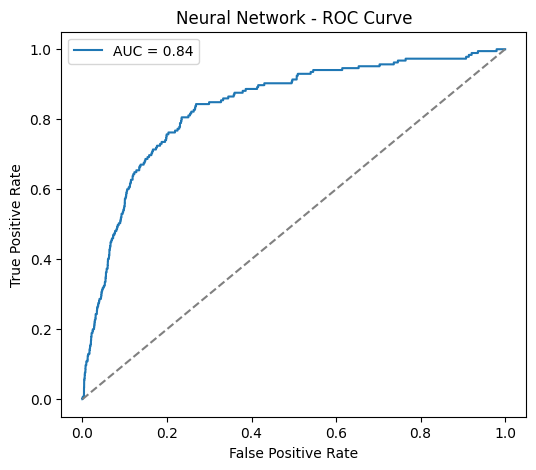

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

for name, y_pred in y_preds.items():
    print(f"\n{name} Evaluation Metrics:")
    print("-"*40)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Precision, Recall, F1
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC AUC
    y_proba = trained_pipelines[name].predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(trained_pipelines[name], X_test, y_test)
    disp.figure_.suptitle(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(f"{name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


Silhouette Score: 0.2835


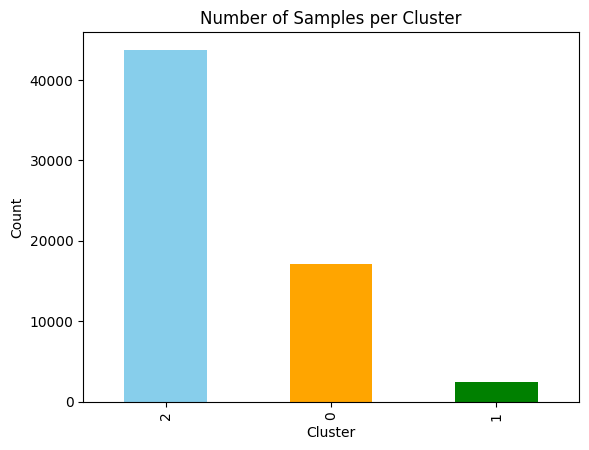

In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

X_all = df.drop('Claim', axis=1)

kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=3, random_state=RANDOM_STATE))
])

kmeans_pipeline.fit(X_all)

clusters = kmeans_pipeline.named_steps['kmeans'].labels_

df['Cluster'] = clusters

sil_score = silhouette_score(preprocessor.fit_transform(X_all), clusters)
print(f"Silhouette Score: {sil_score:.4f}")

df['Cluster'].value_counts().plot(kind='bar', color=['skyblue','orange','green'])
plt.title("Number of Samples per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


In [13]:
from sklearn.pipeline import Pipeline

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=RANDOM_STATE)
}

trained_pipelines = {}
y_preds = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ])),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline
    y_preds[name] = pipeline.predict(X_test)

In [14]:
metrics_list = []

for name, pipeline in trained_pipelines.items():
    y_pred = pipeline.predict(X_test)

    if hasattr(pipeline.named_steps['classifier'], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:,1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc_auc = None

    metrics_list.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'AUC': roc_auc
    })

metrics_df = pd.DataFrame(metrics_list)

display(metrics_df)

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Logistic Regression,0.795200,0.051731,0.751351,0.096797,0.831206
1,Decision Tree,0.971341,0.067961,0.075676,0.071611,0.531920
2,Neural Network,0.985394,0.000000,0.000000,0.000000,0.838303


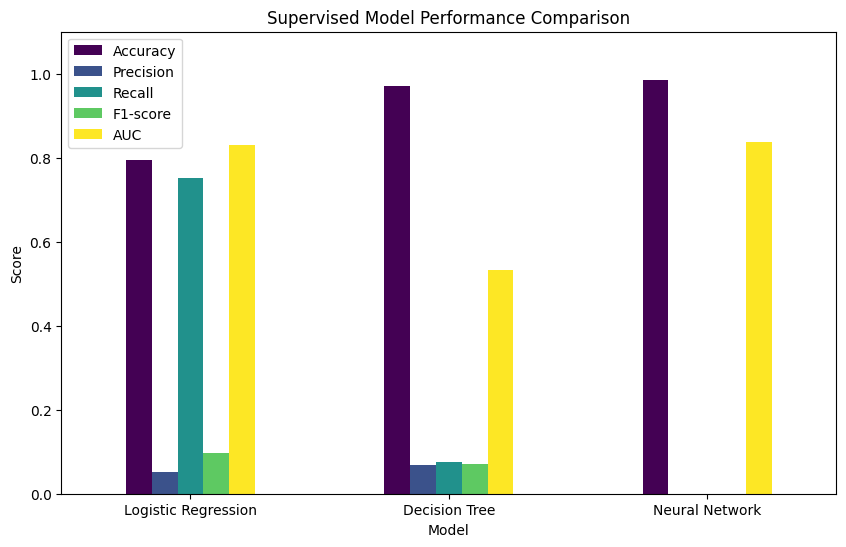

In [15]:
metrics_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']].plot(
    kind='bar', figsize=(10,6), rot=0, colormap='viridis'
)
plt.title("Supervised Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1.1)
plt.show()

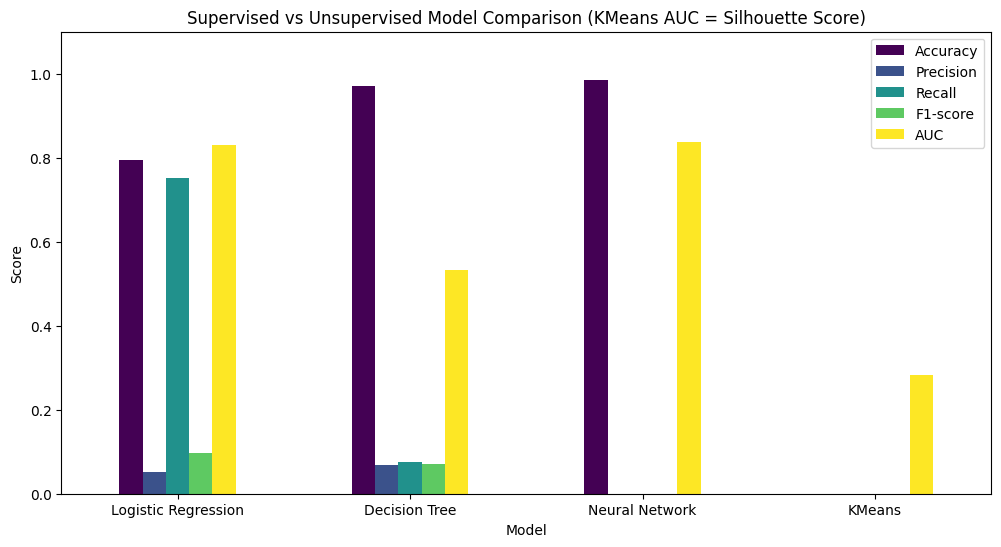

In [16]:
kmeans_row = pd.DataFrame([{
    'Model': 'KMeans',
    'Accuracy': None,
    'Precision': None,
    'Recall': None,
    'F1-score': None,
    'AUC': sil_score
}])

metrics_with_kmeans = pd.concat([metrics_df, kmeans_row], ignore_index=True)

metrics_with_kmeans.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC']].plot(
    kind='bar', figsize=(12,6), rot=0, colormap='viridis'
)
plt.title("Supervised vs Unsupervised Model Comparison (KMeans AUC = Silhouette Score)")
plt.ylabel("Score")
plt.ylim(0,1.1)
plt.show()